<a href="https://colab.research.google.com/github/moira-du-monde/QDM_SGI/blob/main/SGI_QDMs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Encoding systems of geographic information in quantum density matrices**

This notebook contains and explains the code for the 2023 paper 'Encoding systems of geographic information in quantum density matrices' (Under review - author name redacted).

## Libraries and dependencies

As an exercise in understanding and to extend the lifespan of these scripts, I (the paper's author) have primarily used basic Python libraries to develop the program and analysis from the ground up.  Functions for calculating density matrices and their evolutions, as well as metrics like entropy and trace distance are written using

- numpy
- pandas
- math
- cmath
- scipy

However, I also turn to the Quantum Computing library [Qutip](https://qutip.org/docs/3.1.0/guide/guide-visualization.html) and the more general matplotlib for help visualizing the data in phase space.

In [1]:
# optional for 3D and interactive plotting:

%%capture
!pip install ipympl
!pip install open3d
!pip install igraph
!pip install ipywidgets


In [2]:
%%capture
!pip install qutip

In [3]:
%%capture
!pip install Pillow==9.0.0

In [4]:
# import libs and packages

# general
import numpy as np
import pandas as pd
from numpy import linalg as la
from numpy.ma.core import log
import math
import cmath
import ipympl
import matplotlib.pyplot as plt
import scipy.linalg as linalg
from scipy import sparse
from functools import reduce

# qutip
from qutip import *
from qutip.tomography import _index_permutations

# viz
import ipympl, ipywidgets, igraph
%matplotlib inline
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

## 1.  Choosing and visualizing a computational basis

Quantum systems are often described in the simplest possible terms, wherein each qubit of information can be represented as a 0 or 1 to signify the system's orthogonal states (e.g., direction, spin, location, etc).  The number of qubits needed to distinguish between different states of the system depends on its complexity (N) and must satisfy the equation N = 2^n.  For example, systems with just 2 possible states just need 1 qubit to describe them in full, since where N = 2, n = 1.  By contrast, systems with 8 possible states need 3 qubits to distinguish among them, because where N = 8, n = 3.  When two or more systems like these are entangled, we can use the density matrix formalism to encode each possible state of the 3 qubits and the probabilities associated with each state.



In [5]:
# print out the 8 possible states

for i in range(2):
    for j in range(2):
        for k in range(2):
            print(f"{i}{j}{k}")

000
001
010
011
100
101
110
111


In [6]:
# the basis will have ones on the diag and zeros on the off diag

def diagonal_array(input_array):
    """
    Converts an nx1 input array to an nxn diagonal array.

    Args:
        input_array (ndarray): A 1D numpy array of shape (n,).

    Returns:
        ndarray: A 2D numpy array of shape (n, n), where the diagonal elements
        are the values of the input array, and all other elements are zero.
    """
    n = len(input_array)
    output_array = np.zeros((n, n))
    np.fill_diagonal(output_array, input_array)
    return output_array

In [7]:
# Define the basis states for 3 qubits

# define the basis states
zero = np.array([[1], [0]])
one = np.array([[0], [1]])

# create the 3-qubit basis states using Kronecker products
state_000 = np.kron(np.kron(zero, zero), zero)
state_001 = np.kron(np.kron(zero, zero), one)
state_010 = np.kron(np.kron(zero, one), zero)
state_011 = np.kron(np.kron(zero, one), one)
state_100 = np.kron(np.kron(one, zero), zero)
state_101 = np.kron(np.kron(one, zero), one)
state_110 = np.kron(np.kron(one, one), zero)
state_111 = np.kron(np.kron(one, one), one)

# construct the matrix using the basis states
matrix = np.concatenate((state_000, state_001, state_010, state_011, state_100, state_101, state_110, state_111), axis=1, dtype = complex)

# print the matrix
print(matrix)

# Compute the norm of the tensor product
norm = np.linalg.norm(matrix)

# Normalize the tensor product
normalized_state = matrix / norm


[[1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 1.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 1.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 1.+0.j]]


In [8]:
# define probabilities assoc with each observed state

prob_000 = np.array([1,0,0,0,0,0,0,0])
prob_001 = np.array([0,1,0,0,0,0,0,0])
prob_010 = np.array([0,0,1,0,0,0,0,0])
prob_011 = np.array([0,0,0,1,0,0,0,0])
prob_100 = np.array([0,0,0,0,1,0,0,0])
prob_101 = np.array([0,0,0,0,0,1,0,0])
prob_110 = np.array([0,0,0,0,0,0,1,0])
prob_111 = np.array([0,0,0,0,0,0,0,1])

states = [prob_000, prob_001, prob_010, prob_011, prob_100, prob_101, prob_110, prob_111]
pure = []

for i in states:
  pure.append(diagonal_array(i))

m = []

for i in pure:
  m.append(i*matrix)

dml = []

for i in m:
  dml.append(Qobj(i))

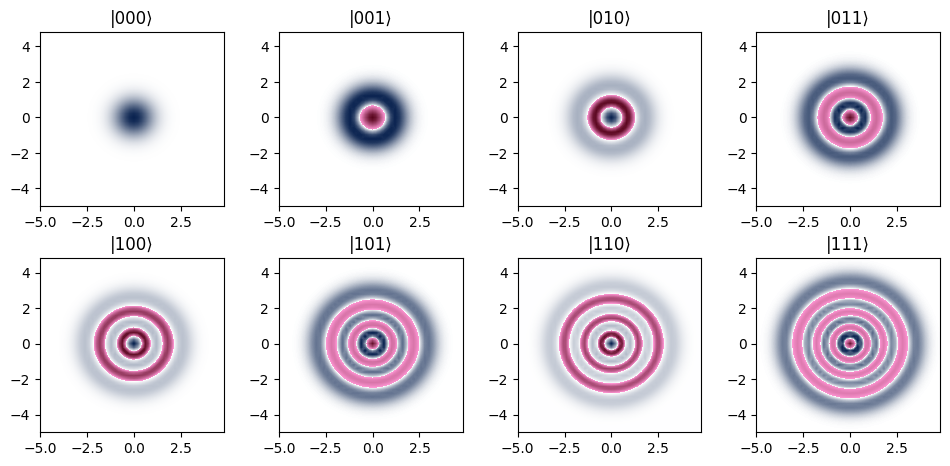

In [9]:
# Define the Wigner functions
xvec = np.arange(-5, 5, 10.0 / 50)
yvec = xvec

X, Y = np.meshgrid(xvec, yvec)

W1 = wigner(dml[0], xvec, yvec)
W2 = wigner(dml[1], xvec, yvec)
W3 = wigner(dml[2], xvec, yvec)
W4 = wigner(dml[3], xvec, yvec)
W5 = wigner(dml[4], xvec, yvec)
W6 = wigner(dml[5], xvec, yvec)
W7 = wigner(dml[6], xvec, yvec)
W8 = wigner(dml[7], xvec, yvec)

# Create the facet plot
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(10, 5))

cmapW1 = wigner_cmap(W1)
axes[0, 0].contourf(X,Y,W1,500,cmap = cmapW1)
axes[0, 0].set_title('|000⟩')

cmapW2 = wigner_cmap(W2)
axes[0, 1].contourf(X,Y,W2,500,cmap = cmapW2)
axes[0, 1].set_title('|001⟩')

cmapW3 = wigner_cmap(W3)
axes[0, 2].contourf(X,Y,W3,500,cmap = cmapW3)
axes[0, 2].set_title('|010⟩')

cmapW4 = wigner_cmap(W4)
axes[0, 3].contourf(X,Y,W4,500,cmap = cmapW4)
axes[0, 3].set_title('|011⟩')

cmapW5 = wigner_cmap(W5)
axes[1, 0].contourf(X,Y,W5,500,cmap = cmapW5)
axes[1, 0].set_title('|100⟩')

cmapW6 = wigner_cmap(W6)
axes[1, 1].contourf(X,Y,W6,500,cmap = cmapW6)
axes[1, 1].set_title('|101⟩')
  
cmapW7 = wigner_cmap(W7)
axes[1, 2].contourf(X,Y,W7,500,cmap = cmapW7)
axes[1, 2].set_title('|110⟩')

cmapW8 = wigner_cmap(W8)
axes[1, 3].contourf(X,Y,W8,500,cmap = cmapW8)
axes[1, 3].set_title('|111⟩')

# Adjust the spacing between the subplots
plt.subplots_adjust(left=0.05, bottom=0.1, right=0.95, top=0.9, wspace=0.3, hspace=0.3)
plt.show()

## 2. Spatiotemporal autocorrelation & multi-partite entanglement


Let H_A and H_B be two 3 qubit systems whose opposite values (0 or 1) represent the degree of non-locality in explaining a system's state (lowercase s) for the market and lumber production systems in Von Thunen's Isolated State (uppercase S).  For each system, we may define qubit 1 as the state at space-time t-1, qubit 2 as the state at space-time t, and qubit 3 as the state at t+1.  This is conceptually similar to the "superdensity" matrix formalism described by Cotler et al. (2018), but instead of using the system's Hamiltonian to calculate the time evolution of each subsystem, we will make use of multi-partite entanglement, which is a fundamental aspect of quantum information theory that explains entanglement between qubits in the same system (I refer to this class of relationships as "local") as well as more generic entanglement between two or more systems (what I call "non-local").

To calculate the joint density matrices that describe H_A and H_B, we will stylistically assign probabilities to various states in their 6 subsystems (3 for each joint system).

Formally, DOs are positive, semi-definite Hermitian operator of trace = 1 acting on the Hilbert space of the system.  In the case of the mixed state represented by the ket |ψ〉prepared with the ensemble probability *p-sub-j*,  where the bra 〈ψ| is its Hermitian conjugate, the density operator is

>ρ = Σ*p-sub-j*  |ψ-sub-j〉*〈ψ-sub-j|

We obtain the DM by the choice of a basis in the DO's underlying space. 

Variable inputs:

ket = column vector of dimension 1 x D populated by possible states of the system

bra = ket's conjugate transpose (which itself is a row vector of dimension D x 1)

probs = D x D matrix of weighted probabilities for each state

In [10]:
def construct_density_matrices(probabilities_list):
    density_matrices = []
    
    for probabilities in probabilities_list:
        # Step 1: Calculate square root of probabilities
        sqrt_probabilities = np.sqrt(probabilities)
        
        # Step 2: Normalize the ket vector
        ket = sqrt_probabilities / np.linalg.norm(sqrt_probabilities)
        
        # Step 3: Calculate the density matrix
        density_matrix = np.outer(ket, np.conj(ket))
        
        # Ensure the density matrix is Hermitian
        density_matrix = (density_matrix + np.conj(density_matrix.T)) / 2.0
        
        density_matrices.append(density_matrix)
    
    return density_matrices


In [11]:
# Define the list of probability arrays

probabilities_sub_HA = [[0.2, 0.8], [0.5, 0.5], [0.3, 0.7]]
probabilities_sub_HB = [[0.8, 0.2], [0.5, 0.5], [0.7, 0.3]]

# Construct the density matrices
qdm_sub_HA = construct_density_matrices(probabilities_sub_HA)
qdm_sub_HB = construct_density_matrices(probabilities_sub_HB)

# If interested, display the density matrices
# for i, density_matrix in enumerate(result):
#     print(f"Density Matrix {i+1}:")
#     print(density_matrix)
#     print()

for i in qdm_sub_HA:
  HA_prev = np.array(qdm_sub_HA[0], dtype = complex)
  HA_pres = np.array(qdm_sub_HA[1], dtype = complex)
  HA_post = np.array(qdm_sub_HA[2], dtype = complex)

for i in qdm_sub_HB:
  HB_prev = np.array(qdm_sub_HB[0], dtype = complex)
  HB_pres = np.array(qdm_sub_HB[1], dtype = complex)
  HB_post = np.array(qdm_sub_HB[2], dtype = complex)


In [12]:
print("H_A components:")
print(HA_prev)
print(HA_pres)
print(HA_post)

H_A components:
[[0.2+0.j 0.4+0.j]
 [0.4+0.j 0.8+0.j]]
[[0.5+0.j 0.5+0.j]
 [0.5+0.j 0.5+0.j]]
[[0.3       +0.j 0.45825757+0.j]
 [0.45825757+0.j 0.7       +0.j]]


In [13]:
print("H_B components:")
print(HB_prev)
print(HB_pres)
print(HB_post)

H_B components:
[[0.8+0.j 0.4+0.j]
 [0.4+0.j 0.2+0.j]]
[[0.5+0.j 0.5+0.j]
 [0.5+0.j 0.5+0.j]]
[[0.7       +0.j 0.45825757+0.j]
 [0.45825757+0.j 0.3       +0.j]]


*Constructing and visualizing the intermediate joint matrices*

After defining the past, present, and future states for market demand (H_A) and lumber supply (H_B), we can calculate the joint states and take a look at the Wigner map of these intermediate matrices, which we will want to compare our final matrices.

In [14]:
# to calculate the joint QDMs H_A and H_B:

def calculate_joint_density_matrix(density_matrices):
    joint_density_matrix = np.kron(density_matrices[0], density_matrices[1])
    joint_density_matrix = np.kron(joint_density_matrix, density_matrices[2])
    
    # Ensure the joint density matrix is Hermitian
    joint_density_matrix = (joint_density_matrix + np.conj(joint_density_matrix.T)) / 2.0
    joint_density_matrix = np.array(joint_density_matrix, dtype = complex)
    
    return joint_density_matrix


In [15]:
# construct a list of each sub-system
sub_HA = [HA_prev, HA_pres, HA_post]
sub_HB = [HB_prev, HB_pres, HB_post]


# calculate the joint density matrices from those lists
int_HA = calculate_joint_density_matrix(sub_HA)
int_HB = calculate_joint_density_matrix(sub_HB)


# Display the joint density matrix
print("Joint Density Matrix:")
print(int_HA)

Joint Density Matrix:
[[0.03      +0.j 0.04582576+0.j 0.03      +0.j 0.04582576+0.j
  0.06      +0.j 0.09165151+0.j 0.06      +0.j 0.09165151+0.j]
 [0.04582576+0.j 0.07      +0.j 0.04582576+0.j 0.07      +0.j
  0.09165151+0.j 0.14      +0.j 0.09165151+0.j 0.14      +0.j]
 [0.03      +0.j 0.04582576+0.j 0.03      +0.j 0.04582576+0.j
  0.06      +0.j 0.09165151+0.j 0.06      +0.j 0.09165151+0.j]
 [0.04582576+0.j 0.07      +0.j 0.04582576+0.j 0.07      +0.j
  0.09165151+0.j 0.14      +0.j 0.09165151+0.j 0.14      +0.j]
 [0.06      +0.j 0.09165151+0.j 0.06      +0.j 0.09165151+0.j
  0.12      +0.j 0.18330303+0.j 0.12      +0.j 0.18330303+0.j]
 [0.09165151+0.j 0.14      +0.j 0.09165151+0.j 0.14      +0.j
  0.18330303+0.j 0.28      +0.j 0.18330303+0.j 0.28      +0.j]
 [0.06      +0.j 0.09165151+0.j 0.06      +0.j 0.09165151+0.j
  0.12      +0.j 0.18330303+0.j 0.12      +0.j 0.18330303+0.j]
 [0.09165151+0.j 0.14      +0.j 0.09165151+0.j 0.14      +0.j
  0.18330303+0.j 0.28      +0.j 0.1833030

In [16]:
int_HB

array([[0.28      +0.j, 0.18330303+0.j, 0.28      +0.j, 0.18330303+0.j,
        0.14      +0.j, 0.09165151+0.j, 0.14      +0.j, 0.09165151+0.j],
       [0.18330303+0.j, 0.12      +0.j, 0.18330303+0.j, 0.12      +0.j,
        0.09165151+0.j, 0.06      +0.j, 0.09165151+0.j, 0.06      +0.j],
       [0.28      +0.j, 0.18330303+0.j, 0.28      +0.j, 0.18330303+0.j,
        0.14      +0.j, 0.09165151+0.j, 0.14      +0.j, 0.09165151+0.j],
       [0.18330303+0.j, 0.12      +0.j, 0.18330303+0.j, 0.12      +0.j,
        0.09165151+0.j, 0.06      +0.j, 0.09165151+0.j, 0.06      +0.j],
       [0.14      +0.j, 0.09165151+0.j, 0.14      +0.j, 0.09165151+0.j,
        0.07      +0.j, 0.04582576+0.j, 0.07      +0.j, 0.04582576+0.j],
       [0.09165151+0.j, 0.06      +0.j, 0.09165151+0.j, 0.06      +0.j,
        0.04582576+0.j, 0.03      +0.j, 0.04582576+0.j, 0.03      +0.j],
       [0.14      +0.j, 0.09165151+0.j, 0.14      +0.j, 0.09165151+0.j,
        0.07      +0.j, 0.04582576+0.j, 0.07      +0.j, 0.

In [17]:
# use the QuTip Wigner function to visualize; must convert QDMs to quantum objects to be compatible

int_HA_q = Qobj(int_HA)
int_HB_q = Qobj(int_HB)

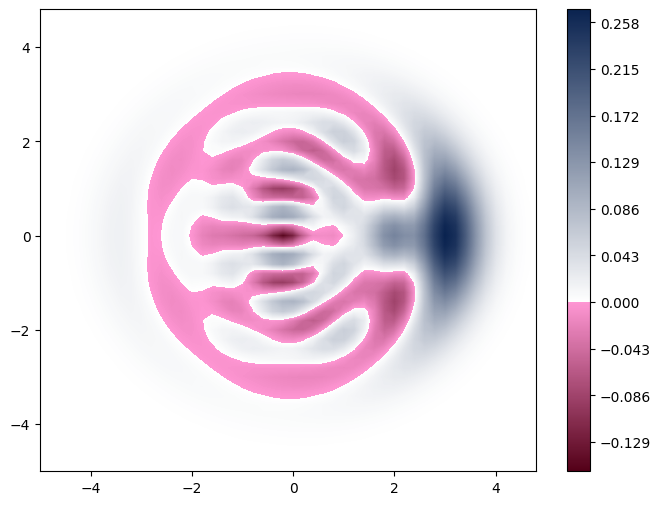

In [18]:
x = int_HA_q
xvec = np.arange(-5, 5, 10.0 / 50)
yvec = xvec
W_j = wigner(x, xvec, yvec)
cmap = wigner_cmap(W_j)
X, Y = np.meshgrid(xvec, yvec)
fig = plt.figure(figsize=(8,6))
plt.contourf(X, Y, W_j, 500, cmap=cmap)
plt.colorbar()
plt.savefig('/content/drive/MyDrive/NextGIS/Artwork/wigner_superd_1.jpeg', dpi=300)

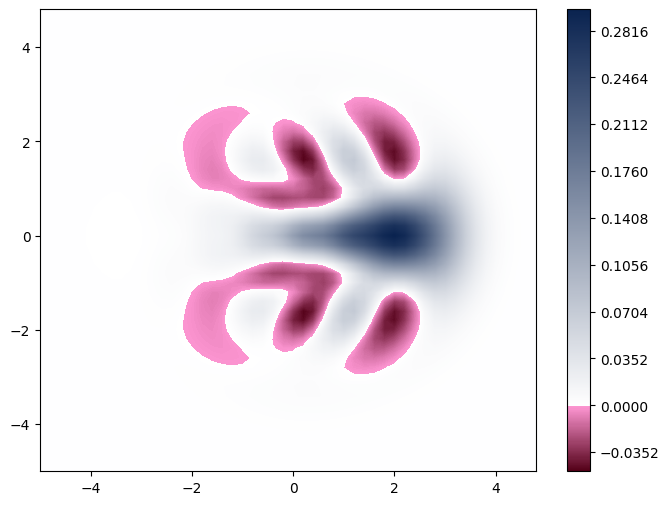

In [19]:
x = int_HB_q
xvec = np.arange(-5, 5, 10.0 / 50)
yvec = xvec
W_j = wigner(x, xvec, yvec)
cmap = wigner_cmap(W_j)
X, Y = np.meshgrid(xvec, yvec)
fig = plt.figure(figsize=(8,6))
plt.contourf(X, Y, W_j, 500, cmap=cmap)
plt.colorbar()
plt.savefig('/content/drive/MyDrive/NextGIS/Artwork/wigner_superd_2.jpeg', dpi=300)

## 3. Composite matrices

Once we've got the joint QDMs, we can use the same "calculate_joint_density_matrix" to generate the QDM for the full composite system (i.e., the market and the lumber production supply parts of the isolated state).

In [20]:
# construct a list of each sub-system
HA_HB = [int_HA, int_HB]

def calculate_composite(density_matrices):
    composite = np.kron(density_matrices[0], density_matrices[1])
    
    # Ensure the joint density matrix is Hermitian
    composite = (composite + np.conj(composite.T)) / 2.0
    composite = np.array(composite, dtype = complex)
    
    return composite

# calculate the joint density matrices from those lists
iso_state = calculate_composite(HA_HB)

# Display the joint density matrix
print("Composite system:")
print(iso_state)

Composite system:
[[0.0084    +0.j 0.00549909+0.j 0.0084    +0.j ... 0.0084    +0.j
  0.01283121+0.j 0.0084    +0.j]
 [0.00549909+0.j 0.0036    +0.j 0.00549909+0.j ... 0.00549909+0.j
  0.0084    +0.j 0.00549909+0.j]
 [0.0084    +0.j 0.00549909+0.j 0.0084    +0.j ... 0.0084    +0.j
  0.01283121+0.j 0.0084    +0.j]
 ...
 [0.0084    +0.j 0.00549909+0.j 0.0084    +0.j ... 0.0084    +0.j
  0.01283121+0.j 0.0084    +0.j]
 [0.01283121+0.j 0.0084    +0.j 0.01283121+0.j ... 0.01283121+0.j
  0.0196    +0.j 0.01283121+0.j]
 [0.0084    +0.j 0.00549909+0.j 0.0084    +0.j ... 0.0084    +0.j
  0.01283121+0.j 0.0084    +0.j]]


In [21]:
iso_state_q = Qobj(iso_state)

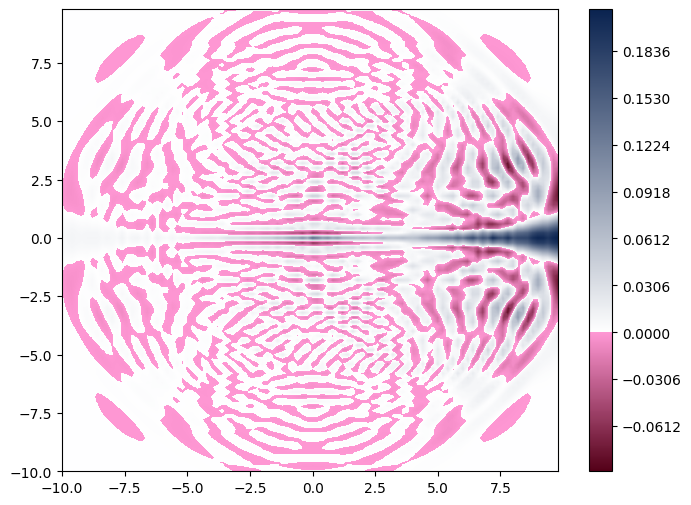

In [23]:
x = iso_state_q
xvec = np.arange(-10, 10, 10.0 / 50)
yvec = xvec
W_j = wigner(x, xvec, yvec)
cmap = wigner_cmap(W_j)
X, Y = np.meshgrid(xvec, yvec)
fig = plt.figure(figsize=(8,6))
plt.contourf(X, Y, W_j, 500, cmap=cmap)
plt.colorbar()
plt.savefig('/content/drive/MyDrive/NextGIS/Artwork/wigner_composite.jpeg', dpi=300)

## 4.  Checking assumptions

Before we calculate the final density matrices of our two entangled systems, we should double-check that each of our assumptions hold for our intermediate and joint QDMs. 

In [24]:
# prep function for testing whether individual matrices are Hermitian

def is_hermitian(matrix):
    # Check if the matrix is square
    if matrix.shape[0] != matrix.shape[1]:
        return False

    # Check if the matrix is equal to its conjugate transpose
    conjugate_transpose = np.conjugate(np.transpose(matrix))
    if not np.allclose(matrix, conjugate_transpose):
        return False

    # Check if the trace of the matrix is equal to 1
    trace = np.trace(matrix)
    if not np.isclose(trace, 1):
        return False

    return True

is_hermitian_and_trace_one = is_hermitian(iso_state)
print("Is the joint density matrix Hermitian with trace = 1?", is_hermitian_and_trace_one)


Is the joint density matrix Hermitian with trace = 1? True


In [25]:
is_hermitian_and_trace_one = is_hermitian(int_HA)
print("Is the joint density matrix Hermitian with trace = 1?", is_hermitian_and_trace_one)


Is the joint density matrix Hermitian with trace = 1? True


*Testing for entanglement*

We suspect that ℌ-sub-A and ℌ-sub-B are entangled, such that the state of ℌ-sub-A is correlated with the state of ℌ-sub-B.  This would mean the space of the full system ℌ cannot be written as the tensor product of ℌ-sub-A and ℌ-sub-B because there are no states  |x〉 ⊗ |y〉of ℌ-sub-A and ℌ-sub-B respectively that produce the state |z〉of ℌ.  In such a case, Al (H and Bob can know something about the state of the other's systems by taking a measurement of their own.  Therefore it is not correct to consider ℌ-sub-A and ℌ-sub-B independently, and ℌ is not separable.

To test this hypothesis, we will lean on the Schmidt decomposition proof, which guarantees that to be able to write the state |z〉of ℌ as a tensor product (e.g., of states  |x〉 ⊗ |y〉of ℌ-sub-A and ℌ-sub-B), the sum of |λ-sub-α|^2 = 1.  Here, λ-sub-α is the parameter of probabilities for the possible states of each system.  If there is only one λ-sub-α = 1, there is no entanglement.  If many λ-sub-α != 0,  |z〉cannot be written as a tensor product, and we can say the subsystems are entangled.


In [26]:
# use Schmidt value decomposition to test

iso_state_sva = la.svd(iso_state, full_matrices=True)
iso_state_sva

(array([[-9.16515139e-02+0.j,  7.93513486e-01+0.j,  5.21962379e-01+0.j,
         ...,  1.67140836e-19+0.j, -2.26617506e-17+0.j,
         -2.90864731e-01+0.j],
        [-6.00000000e-02+0.j,  3.90431894e-02+0.j, -1.08645360e-01+0.j,
         ..., -2.87084694e-02+0.j, -3.52539976e-02+0.j,
         -9.75377807e-02+0.j],
        [-9.16515139e-02+0.j, -4.07237353e-02+0.j, -2.90915614e-02+0.j,
         ...,  4.96492252e-03+0.j,  3.23274087e-03+0.j,
         -9.97432192e-02+0.j],
        ...,
        [-9.16515139e-02+0.j,  8.46399291e-02+0.j, -7.78234589e-02+0.j,
         ...,  2.29568507e-02+0.j,  2.59284035e-02+0.j,
          1.29654644e-01+0.j],
        [-1.40000000e-01+0.j, -6.73281513e-02+0.j,  1.02124628e-01+0.j,
         ..., -7.53500821e-02+0.j,  1.54819793e-02+0.j,
          2.72250181e-02+0.j],
        [-9.16515139e-02+0.j,  8.46399291e-02+0.j, -7.78234589e-02+0.j,
         ...,  5.79246875e-02+0.j,  3.31896905e-02+0.j,
          1.29654644e-01+0.j]]),
 array([1.00000000e+00, 9.94995

In [27]:
def entropy(rho):
    """
    Calculate the von Neumann entropy of the dms
    """
    # Calculate the eigenvalues of the density matrix
    eigvals = np.linalg.eigvalsh(rho)

    # Remove any eigenvalues that are zero
    eigvals = eigvals[eigvals > 0]

    # Calculate the von Neumann entropy
    S = -np.sum(eigvals * np.log2(eigvals))

    return S

# Define the density matrix with off-diagonal elements of zero
# rho = np.diag([0.2, 0.3, 0.5])


In [29]:
# Calculate the entropy of the density matrices
S_int_HA = entropy(int_HA)* -1
S_int_HB = entropy(int_HA) * -1
S_iso_state = entropy(iso_state)

# Print the result
print("Entropy HA:", S_int_HA) # 3.377515000259281e-16
print("Entropy HB:", S_int_HB) # 3.377515000259281e-16
print("Entropy Full:", S_iso_state) # 7.444557358459444e-15

Entropy HA: 3.377515000259281e-16
Entropy HB: 3.377515000259281e-16
Entropy Full: 4.8280489458886094e-15


In [30]:
S_iso_state > S_int_HA

True

In [31]:
def trace_distance(rho1, rho2):
    """
    Calculate the trace distance between two density matrices with off-diagonal elements of zero.
    """
    # Calculate the eigenvalues of the difference between the two density matrices
    eigvals = np.abs(np.linalg.eigvalsh(rho1 - rho2))

    # Calculate the trace distance
    D = 0.5 * np.sum(eigvals)

    return D

In [32]:
print("Trace distance H_A and H_B:", trace_distance(int_HA, int_HB))

Trace distance H_A and H_B: 0.6800000000000006


## 5. Calculating the reduced density matrices



We can double check our work by making sure the reduced density matrices of H_A and H_B are equal to our intermediate QDMs from step 2.

Although we have just proved our composite system is not separable, we built the system by combining its individual factors, which presents a contradiction.  In fact we can  extend the separability assumption (i.e., the state |ψ〉is separable, so |ψ〉=  |H_A〉⊗ |H_B〉) to any entangled state because it is possible to define an entangled state of the combined subsystems as

>|ψ〉= Σ from u = 0 to N Σ from v = 0 to M α-sub-u-v |φ-sub-u〉⊗ |χ-sub-v〉

even though the ket psi may not officially represent ℌ. Once we have defined the relevant basis (e.g., of B) and our assumptions are set, we'll calculate the *partial trace* of the basis (Tr-sub-B) over the whole system H to find the RDM of H_Ausing

>(ρ-sub-A) = Tr-sub-B(ρ-sub-A-B) = Σ from v = 0 to M (I-sub-A  ⊗ 〈χ-sub-v| )|ψ〉〈ψ|(I-sub-A ⊗ |χ-sub-v〉)

Where I-sub-A is A's Identity matrix (ones on diagonal, zeros everywhere else).  [Diego Emilio](https://www.youtube.com/watch?v=L70TVZHYOsM&list=PLhI5X1mNN8ghnH1ckAcclxY6-CPmZvWrk&index=11) has a video that explains the formula clearly and in two parts.  Part one

>(I-sub-A  ⊗ 〈χ-sub-v| )|ψ〉

is the equivalent of |a〉(〈χ-sub-v|b〉), which is the probability amplitude of measuring state 〈χ-sub-v|, which we've [defined elsewhere](link) as α-sub-v.

Part two 
>〈ψ|(I-sub-A ⊗ |χ-sub-v〉) 

is the probability amplitude's Hermitian conjugate α-star-sub-v.

Together this yields a reduced density matrix 

>(ρ-sub-A) = Σ from v = 0 to M (|a〉α-sub-v)(〈a| α-star-sub-v)


In [33]:
# a simple way to do the same

n1 = 8
n2 = 8

iso_tensor=iso_state.reshape([n1, n2, n1, n2]);

rdm_a = np.trace(iso_tensor, axis1=1, axis2=3) #rho_a

rdm_b = np.trace(iso_tensor, axis1=0, axis2=2)

In [34]:
rdm_a_q = Qobj(rdm_a)
rdm_b_q = Qobj(rdm_b)

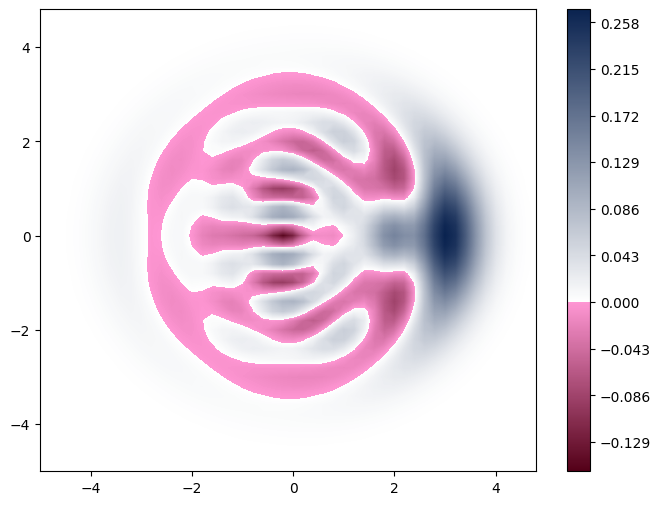

In [35]:
x = rdm_a_q
xvec = np.arange(-5, 5, 10.0 / 50)
yvec = xvec
W_j = wigner(x, xvec, yvec)
cmap = wigner_cmap(W_j)
X, Y = np.meshgrid(xvec, yvec)
fig = plt.figure(figsize=(8,6))
plt.contourf(X, Y, W_j, 500, cmap=cmap)
plt.colorbar()
plt.savefig('/content/drive/MyDrive/NextGIS/Artwork/rdm_A.jpeg', dpi=300)

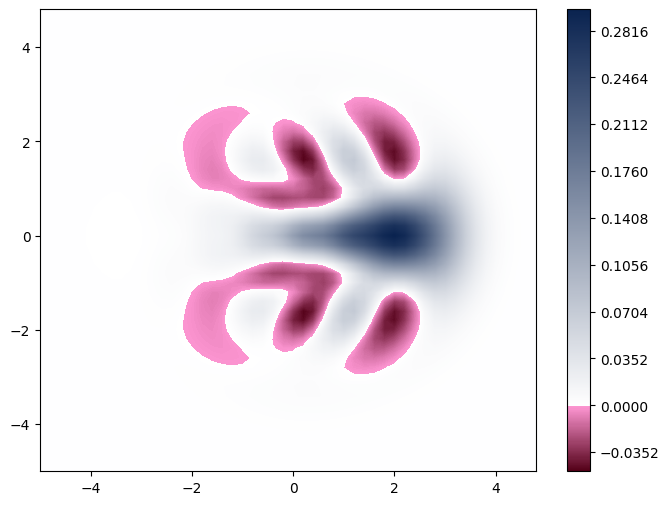

In [36]:
x = rdm_b_q
xvec = np.arange(-5, 5, 10.0 / 50)
yvec = xvec
W_j = wigner(x, xvec, yvec)
cmap = wigner_cmap(W_j)
X, Y = np.meshgrid(xvec, yvec)
fig = plt.figure(figsize=(8,6))
plt.contourf(X, Y, W_j, 500, cmap=cmap)
plt.colorbar()
plt.savefig('/content/drive/MyDrive/NextGIS/Artwork/rdm_B.jpeg', dpi=300)

Looks good!